In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools as it
from tqdm.notebook import tqdm
from modelbase.ode import Model, Simulator

import models


def get_new_y0(s):
    return dict(s.get_results_df().iloc[-1])


def updating_parameter_scan(s, name, values, y0):
    y0 = y0.copy()
    conc = {}
    flux = {}
    for value in tqdm(values, total=len(values)):
        s.clear_results()
        s.initialise(y0)
        s.update_parameter(name, value)
        try:
            t, y = s.simulate(100_000)
            conc[value] = dict(s.get_full_results_df().iloc[-1])
            flux[value] = dict(s.model.get_fluxes_df(y[-1]).iloc[-1])
            y0 = get_new_y0(s)
        except:
            break
    return pd.DataFrame(conc).T, pd.DataFrame(flux).T


def compartmentalise_groups(base_groups: list[str]) -> list[str]:
    groups = []
    for group in base_groups:
        groups.append([f"{i}_meso" for i in group])
        groups.append([f"{i}_bs" for i in group])
    return groups


def is_steady(v, cpd):
    return np.isclose(
        sum(
            v.iloc[-1][k] * val for k, val in m.stoichiometries_by_compounds[cpd].items()
        ),
        0,
    )


def plot_reactions_of_cpd(v, cpd, ax=None):
    rxns = v.loc[:, list(m.stoichiometries_by_compounds[cpd])]
    return rxns.plot(ax=ax, ylim=(np.min(rxns.values) * 0.9, np.max(rxns.values) * 1.1))


def plot_cpd_rhs(v, cpd, ax=None):
    return (
        pd.DataFrame(v[k] * val for k, val in m.stoichiometries_by_compounds[cpd].items())
        .sum()
        .plot(ax=ax, label=cpd)
    )

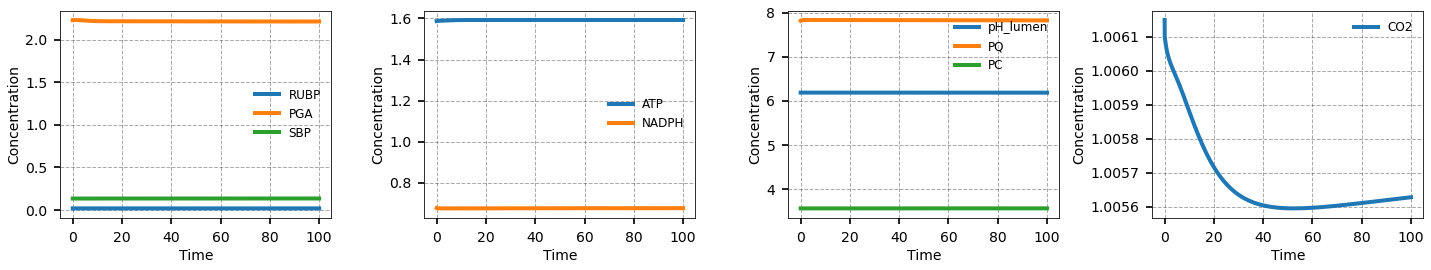

In [4]:
y0 = {
    "PGA": 2.2287343471797025,
    "BPGA": 0.0011395172052077096,
    "GAP": 0.014377954709777471,
    "DHAP": 0.3163149207717971,
    "FBP": 0.032290512863973456,
    "F6P": 1.434383829657654,
    "G6P": 3.2990828070742633,
    "G1P": 0.1913468027816013,
    "SBP": 0.13354114459656463,
    "S7P": 0.39001212495296217,
    "E4P": 0.03247522205016537,
    "X5P": 0.05334449596935596,
    "R5P": 0.08935202710230132,
    "RUBP": 0.018002483554901912,
    "RU5P": 0.03574081022026182,
    "PQ": 7.816317812506009,
    "PC": 3.5654905892762097,
    "Fd": 1.8290228379937157,
    "ATP": 1.5874832946831252,
    "NADPH": 0.6763120766939782,
    "H_lumen": 0.002596276070658352,
    "LHC": 0.6898134476997627,
    "Psbs": 0.9396093683256888,
    "Vx": 0.8977559187171258,
    "TR_ox": 0.7059742923607198,
    "E_inactive": 1.5227432839210808,
    "MDA": 0.00010516387564256525,
    "DHA": 2.7489043868837883e-06,
    "GSSG": 1.3335621272814589e-06,
    "GLYC": 0.014538274163153227,
    "GLYX": 0.21956585389101793,
    "GLY": 11.927538736898514,
    "SER": 1.3081512965652184,
    "HPA": 0.003014225861699743,
    "H2O2": 5.828488769550733e-05,
    "2PG": 3.711365630597338e-06,
    "GLYA": 0.004954584293738558,
    "CO2": 1.0061496713299651,
    "HCO3": 50.30748356649821,
}

m = models.get_c3_mesophyll()

SHARED_PAR_UPDATES = {
    "pfd": 700,
    "O2": 0.1,
    "CO2_ext": 2,
    "k_diffusion_co2": 3.7,  # rough fit to get rubisco to prior behaviour
}

m.update_parameters(SHARED_PAR_UPDATES)
s = Simulator(m)
s.initialise(y0)
s.simulate(100)
s.plot_grid(
    [
        ["RUBP", "PGA", "SBP"],
        ["ATP", "NADPH"],
        ["pH_lumen", "PQ", "PC"],
        ["CO2"],
    ],
    sharey=False,
    xlabels="Time",
    ylabels="Concentration",
)
plt.show()

In [22]:
m = models.get_c3_mesophyll()
m.update_parameters(SHARED_PAR_UPDATES)

s = Simulator(m)
s.update_parameter("pfd", 700)
s.initialise(y0)

co2 = np.linspace(0, 2, 12)
o2 = np.linspace(0, 0.25, 10)
cs, vs = s.parameter_scan_2d_with_fluxes(
    p1=("CO2_ext", co2),
    p2=("O2", o2),
)

rubisco_co2 = np.array([v["rubisco_co2"].values for v in vs.values()])
rubisco_o2 = np.array([v["rubisco_o2"].values for v in vs.values()])
ph = np.array([c["pH_lumen"].values for c in cs.values()])

rubisco_co2[np.isnan(rubisco_co2)] = 0
rubisco_o2[np.isnan(rubisco_o2)] = 0

ERROR! Session/line number was not unique in database. History logging moved to new session 1683


O2:   0%|          | 0/10 [00:00<?, ?it/s]

CO2_ext:   0%|          | 0/12 [00:00<?, ?it/s]

CO2_ext:   0%|          | 0/12 [00:00<?, ?it/s]

CO2_ext:   0%|          | 0/12 [00:00<?, ?it/s]

CO2_ext:   0%|          | 0/12 [00:00<?, ?it/s]

CO2_ext:   0%|          | 0/12 [00:00<?, ?it/s]

CO2_ext:   0%|          | 0/12 [00:00<?, ?it/s]

CO2_ext:   0%|          | 0/12 [00:00<?, ?it/s]

CO2_ext:   0%|          | 0/12 [00:00<?, ?it/s]

CO2_ext:   0%|          | 0/12 [00:00<?, ?it/s]

CO2_ext:   0%|          | 0/12 [00:00<?, ?it/s]

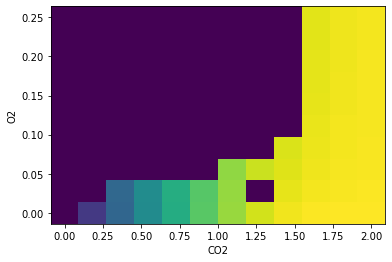

In [31]:
fig, ax = plt.subplots()
ax.pcolormesh(co2, o2, rubisco_co2, shading="auto")
ax.set(xlabel="CO2", ylabel="O2")
plt.show()

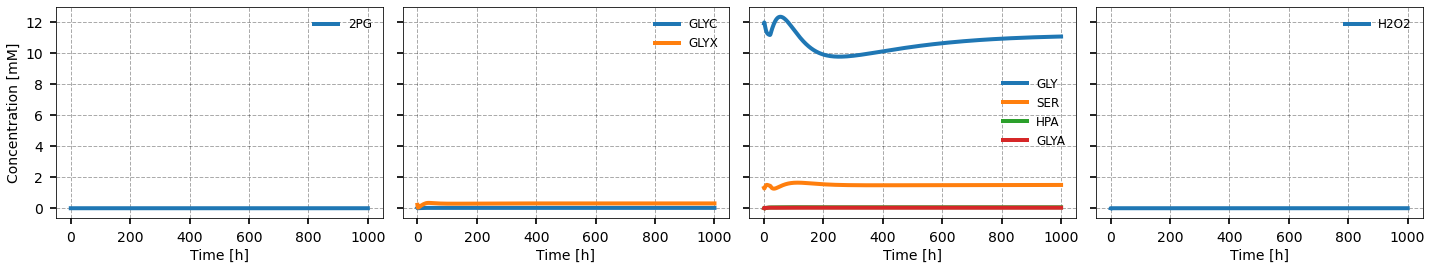

In [46]:
m = models.get_c3_mesophyll()
m.update_parameters(SHARED_PAR_UPDATES)
m.update_parameters(
    {
        "CO2_ext": 1,
        "O2": 0.2,
    }
)

for p in [
    "vmax_glycolate_oxidase",
    "vmax_glycine_transaminase",
    "vmax_ser_gly_transaminase",
    "vmax_glycine_decarboxylase",
]:
    m.parameters[p] = m.parameters[p] * 10


s = Simulator(m)
s.initialise(y0)
t, y = s.simulate(1000)
fig, ax = s.plot_grid(
    [
        ["2PG"],
        ["GLYC", "GLYX"],
        ["GLY", "SER", "HPA", "GLYA"],
        ["H2O2"],
    ],
    xlabels="Time [h]",
    ylabels="Concentration [mM]",
)
fig.tight_layout()
plt.show()

In [47]:
m = models.get_c3_mesophyll()
m.update_parameters(SHARED_PAR_UPDATES)
m.update_parameters(
    {
        "CO2_ext": 1,
        "O2": 0.2,
    }
)

for p in [
    "vmax_glycolate_oxidase",
    "vmax_glycine_transaminase",
    "vmax_ser_gly_transaminase",
    "vmax_glycine_decarboxylase",
]:
    m.parameters[p] = m.parameters[p] * 10

s = Simulator(m)
s.update_parameter("pfd", 700)
s.initialise(y0)

co2 = np.linspace(0, 2, 12)
o2 = np.linspace(0, 0.25, 10)
cs, vs = s.parameter_scan_2d_with_fluxes(
    p1=("CO2_ext", co2),
    p2=("O2", o2),
)

rubisco_co2 = np.array([v["rubisco_co2"].values for v in vs.values()])
rubisco_o2 = np.array([v["rubisco_o2"].values for v in vs.values()])
ph = np.array([c["pH_lumen"].values for c in cs.values()])

rubisco_co2[np.isnan(rubisco_co2)] = 0
rubisco_o2[np.isnan(rubisco_o2)] = 0

O2:   0%|          | 0/10 [00:00<?, ?it/s]

CO2_ext:   0%|          | 0/12 [00:00<?, ?it/s]

CO2_ext:   0%|          | 0/12 [00:00<?, ?it/s]

CO2_ext:   0%|          | 0/12 [00:00<?, ?it/s]

CO2_ext:   0%|          | 0/12 [00:00<?, ?it/s]

CO2_ext:   0%|          | 0/12 [00:00<?, ?it/s]

CO2_ext:   0%|          | 0/12 [00:00<?, ?it/s]

CO2_ext:   0%|          | 0/12 [00:00<?, ?it/s]

CO2_ext:   0%|          | 0/12 [00:00<?, ?it/s]

CO2_ext:   0%|          | 0/12 [00:00<?, ?it/s]

CO2_ext:   0%|          | 0/12 [00:00<?, ?it/s]

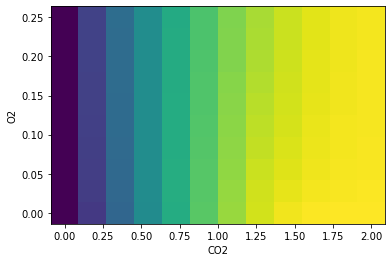

In [48]:
fig, ax = plt.subplots()
ax.pcolormesh(co2, o2, rubisco_co2, shading="auto")
ax.set(xlabel="CO2", ylabel="O2")
plt.show()

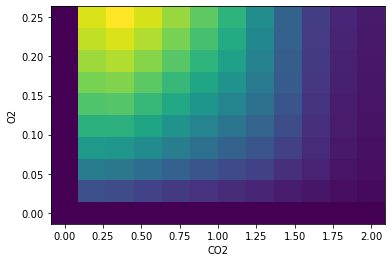

In [49]:
fig, ax = plt.subplots()
ax.pcolormesh(co2, o2, rubisco_o2, shading="auto")
ax.set(xlabel="CO2", ylabel="O2")
plt.show()

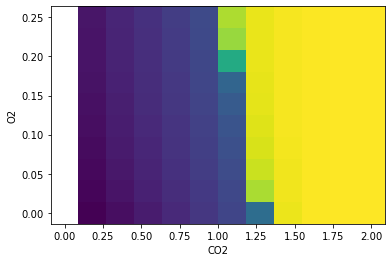

In [52]:
fig, ax = plt.subplots()
ax.pcolormesh(co2, o2, ph, shading="auto")
ax.set(xlabel="CO2", ylabel="O2")
plt.show()

In [56]:
np.nanmin(ph), np.nanmax(ph)

(2.5790153513121608, 6.193353076882564)